## Imports

In [1]:

# number stuff
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

#WCS

from owslib.wcs import WebCoverageService
import rasterio
from rasterio import plot
from PIL import Image
import rioxarray as rxr

# API

import requests


# SoilGrids WCS Exploration


## Exploring WCS

In [2]:
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/bdod.map', version='1.0.0')

In [3]:
print([op.name for op in wcs.operations])

['GetCapabilities', 'DescribeCoverage', 'GetCoverage']


In [4]:
print(len(list(wcs.contents)))

30


In [5]:
print(list(wcs.contents))

['bdod_0-5cm_Q0.5', 'bdod_0-5cm_Q0.05', 'bdod_0-5cm_Q0.95', 'bdod_0-5cm_mean', 'bdod_0-5cm_uncertainty', 'bdod_5-15cm_Q0.5', 'bdod_5-15cm_Q0.05', 'bdod_5-15cm_Q0.95', 'bdod_5-15cm_mean', 'bdod_5-15cm_uncertainty', 'bdod_15-30cm_Q0.5', 'bdod_15-30cm_Q0.05', 'bdod_15-30cm_Q0.95', 'bdod_15-30cm_mean', 'bdod_15-30cm_uncertainty', 'bdod_30-60cm_Q0.05', 'bdod_30-60cm_Q0.5', 'bdod_30-60cm_Q0.95', 'bdod_30-60cm_mean', 'bdod_30-60cm_uncertainty', 'bdod_60-100cm_Q0.05', 'bdod_60-100cm_Q0.5', 'bdod_60-100cm_Q0.95', 'bdod_60-100cm_mean', 'bdod_60-100cm_uncertainty', 'bdod_100-200cm_Q0.05', 'bdod_100-200cm_Q0.5', 'bdod_100-200cm_Q0.95', 'bdod_100-200cm_mean', 'bdod_100-200cm_uncertainty']


In [6]:
names = [k for k in wcs.contents.keys() if k.startswith("bdod_0-5cm")]
print(names)

['bdod_0-5cm_Q0.5', 'bdod_0-5cm_Q0.05', 'bdod_0-5cm_Q0.95', 'bdod_0-5cm_mean', 'bdod_0-5cm_uncertainty']


In [7]:
q0_5_covs = [k for k in wcs.contents.keys() if k.find("Q0.5") != -1]
print(q0_5_covs)

['bdod_0-5cm_Q0.5', 'bdod_5-15cm_Q0.5', 'bdod_15-30cm_Q0.5', 'bdod_30-60cm_Q0.5', 'bdod_60-100cm_Q0.5', 'bdod_100-200cm_Q0.5']


In [8]:
bdod_5_15_median = wcs.contents['bdod_5-15cm_Q0.5']
bdod_5_15_median.supportedCRS

[urn:ogc:def:crs:EPSG::152160,
 urn:ogc:def:crs:EPSG::4326,
 urn:ogc:def:crs:EPSG::3857,
 urn:ogc:def:crs:EPSG::54009,
 urn:ogc:def:crs:EPSG::54012,
 urn:ogc:def:crs:EPSG::152160]

In [9]:
bdod_5_15_median.supportedFormats

['GEOTIFF_INT16']

In [10]:
bdod_5_15_median.boundingboxes

[{'nativeSrs': 'EPSG:4326',
  'bbox': (-179.991347553068,
   -55.9773009202418,
   179.994461880094,
   82.7192840534453)},
 {'nativeSrs': 'EPSG:152160',
  'bbox': (-19949000.0, -6147500.0, 19861750.0, 8361000.0)}]

## Getting Germany Map Segment for mean soil ph at 0-5cm

In [11]:
def get_data(file_path):
    dataarray = rxr.open_rasterio(file_path)
    df = dataarray[0].to_pandas()
    df = df.unstack(level=-1)
    df = df.reset_index()
    df.columns = ['longtitude', 'latitude', 'val']
    return df

In [12]:
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/phh2o.map', version='1.0.0')

In [13]:
phh2o_0_5cm = wcs.contents['phh2o_0-5cm_mean']

In [14]:
phh2o_0_5cm.supportedCRS

[urn:ogc:def:crs:EPSG::152160,
 urn:ogc:def:crs:EPSG::4326,
 urn:ogc:def:crs:EPSG::3857,
 urn:ogc:def:crs:EPSG::54009,
 urn:ogc:def:crs:EPSG::54012,
 urn:ogc:def:crs:EPSG::152160]

In [15]:
phh2o_0_5cm.boundingboxes

[{'nativeSrs': 'EPSG:4326',
  'bbox': (-179.998360809347,
   -55.9773009202418,
   179.994461880094,
   82.7192840534453)},
 {'nativeSrs': 'EPSG:152160',
  'bbox': (-19949750.0, -6147500.0, 19861750.0, 8361000.0)}]

Germany

In [16]:
lon_min = 15
lat_min = 52.5
lon_max = 23
lat_max = 60.8

In [17]:
ger_coord = np.array((lon_min, lat_min, lon_max, lat_max))

In [18]:
bboxger = tuple(ger_coord* 100000)

In [19]:
response = wcs.getCoverage(
    identifier='phh2o_0-5cm_mean', 
    crs='urn:ogc:def:crs:EPSG::152160',
    bbox= bboxger, 
    resx=250, resy=250,
    format='GEOTIFF_INT16')

In [20]:
with open('../raw_data/Germany_pH_0-5_mean.tif', 'wb') as file:
    file.write(response.read())

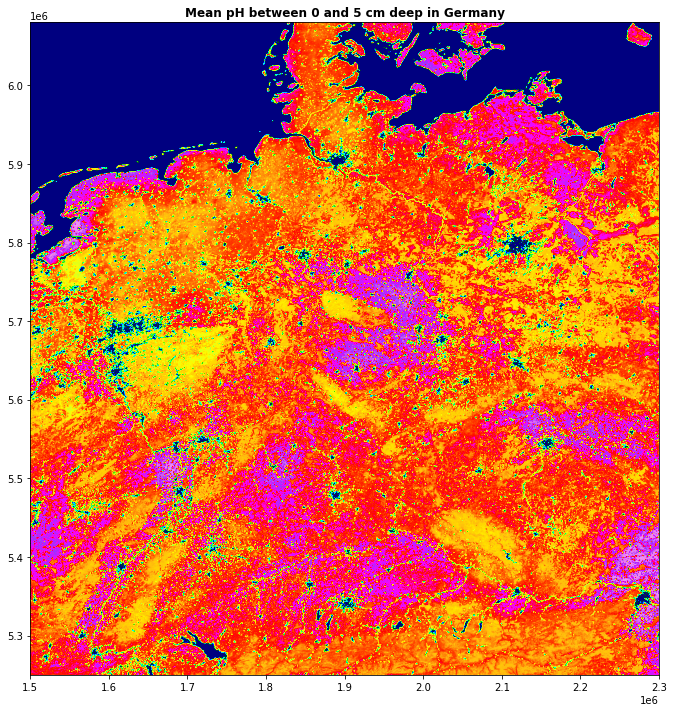

<AxesSubplot:title={'center':'Mean pH between 0 and 5 cm deep in Germany'}>

In [21]:
ph = rasterio.open("../raw_data/Germany_pH_0-5_mean.tif", driver="GTiff")
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(12, 12))
plot.show(ph, title='Mean pH between 0 and 5 cm deep in Germany', cmap='gist_ncar')

In [22]:
df_pH_0_5_mean = get_data('../raw_data/Germany_pH_0-5_mean.tif')

In [23]:
df_pH_0_5_mean

,longtitude,latitude,val
0,1500125.0,6079875.0,0
1,1500125.0,6079625.0,0
2,1500125.0,6079375.0,0
3,1500125.0,6079125.0,0
4,1500125.0,6078875.0,0
...,...,...,...
10623995,2299875.0,5251125.0,58
10623996,2299875.0,5250875.0,60
10623997,2299875.0,5250625.0,62
10623998,2299875.0,5250375.0,64


## Other Features

In [24]:
url_list = ['http://maps.isric.org/mapserv?map=/map/bdod.map', 'http://maps.isric.org/mapserv?map=/map/phh2o.map', 'http://maps.isric.org/mapserv?map=/map/ocd.map']





### Organic carbon density mean at 0-5cm

In [25]:
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/ocd.map', version='1.0.0')

In [26]:
wcs.contents

{'ocd_0-5cm_Q0.5': <owslib.coverage.wcs100.ContentMetadata at 0x14cc56340>,
 'ocd_0-5cm_Q0.05': <owslib.coverage.wcs100.ContentMetadata at 0x14cc56fd0>,
 'ocd_0-5cm_Q0.95': <owslib.coverage.wcs100.ContentMetadata at 0x14cc56520>,
 'ocd_0-5cm_mean': <owslib.coverage.wcs100.ContentMetadata at 0x14cc56280>,
 'ocd_0-5cm_uncertainty': <owslib.coverage.wcs100.ContentMetadata at 0x14cc56c10>,
 'ocd_5-15cm_Q0.5': <owslib.coverage.wcs100.ContentMetadata at 0x14cc56f70>,
 'ocd_5-15cm_Q0.05': <owslib.coverage.wcs100.ContentMetadata at 0x14cc56b50>,
 'ocd_5-15cm_Q0.95': <owslib.coverage.wcs100.ContentMetadata at 0x14cc56760>,
 'ocd_5-15cm_mean': <owslib.coverage.wcs100.ContentMetadata at 0x14cc564f0>,
 'ocd_5-15cm_uncertainty': <owslib.coverage.wcs100.ContentMetadata at 0x14cc56970>,
 'ocd_15-30cm_Q0.05': <owslib.coverage.wcs100.ContentMetadata at 0x14cc56a60>,
 'ocd_15-30cm_Q0.5': <owslib.coverage.wcs100.ContentMetadata at 0x14cc567c0>,
 'ocd_15-30cm_Q0.95': <owslib.coverage.wcs100.ContentMetadat

In [27]:
wcs.contents['ocd_0-5cm_mean'].supportedCRS

[urn:ogc:def:crs:EPSG::152160,
 urn:ogc:def:crs:EPSG::4326,
 urn:ogc:def:crs:EPSG::3857,
 urn:ogc:def:crs:EPSG::54009,
 urn:ogc:def:crs:EPSG::54012,
 urn:ogc:def:crs:EPSG::152160]

In [28]:
response = wcs.getCoverage(
    identifier='ocd_0-5cm_mean', 
    crs='urn:ogc:def:crs:EPSG::152160',
    bbox= bboxger, 
    resx=250, resy=250,
    format='GEOTIFF_INT16')

In [29]:
with open('../raw_data/Germany_ocd_0-5cm_mean.tif', 'wb') as file:
    file.write(response.read())

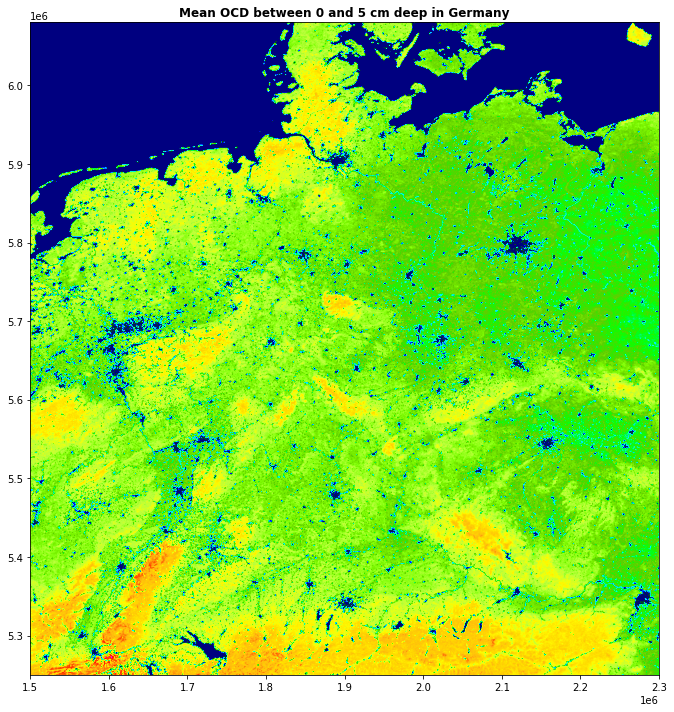

<AxesSubplot:title={'center':'Mean OCD between 0 and 5 cm deep in Germany'}>

In [44]:
ocd = rasterio.open("../raw_data/Germany_ocd_0-5cm_mean.tif", driver="GTiff")
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(12, 12))
plot.show(ocd, title='Mean OCD between 0 and 5 cm deep in Germany', cmap='gist_ncar')

<AxesSubplot:title={'center':'OCD'}>

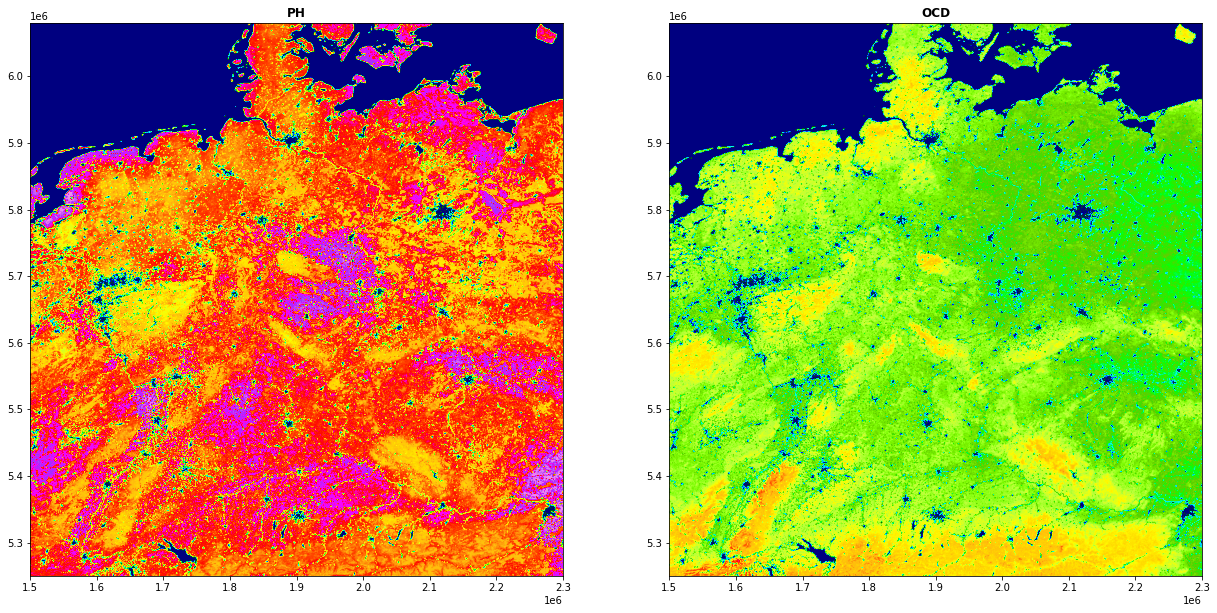

In [45]:
fig, (axl, axr) = plt.subplots(1,2, figsize=(21,11))
plot.show(ph, ax=axl, title='PH', cmap='gist_ncar')
plot.show(ocd, ax=axr, title='OCD', cmap='gist_ncar')

In [47]:
df_ocd_0_5cm_mean = get_data('../raw_data/Germany_ocd_0-5cm_mean.tif')

In [51]:
df_ocd_0_5cm_mean = df_ocd_0_5cm_mean.rename(columns= {'val': 'ocd'})

In [52]:
df_pH_0_5_mean = df_pH_0_5_mean.rename(columns= {'val': 'ph'})

In [55]:
full_df = pd.merge(df_ocd_0_5cm_mean, df_pH_0_5_mean, on= ['longtitude', 'latitude'])

In [56]:
full_df

,longtitude,latitude,ocd,ph
0,1500125.0,6079875.0,0,0
1,1500125.0,6079625.0,0,0
2,1500125.0,6079375.0,0,0
3,1500125.0,6079125.0,0,0
4,1500125.0,6078875.0,0,0
...,...,...,...,...
10623995,2299875.0,5251125.0,374,58
10623996,2299875.0,5250875.0,368,60
10623997,2299875.0,5250625.0,372,62
10623998,2299875.0,5250375.0,367,64


# SoilGrids API

## Query a single pixel point on the soilgrids stack

layer: soilgrids layer name to be queried

depth: specific depth to be queried

values: statistical values

In [32]:
url = 'https://rest.isric.org/soilgrids/v2.0/properties/query'

In [33]:
longitude = 48.570066

In [34]:
latitude = 8.278059

In [35]:
params = {
    'lon': longitude,
    'lat': latitude,
    # options: https://www.isric.org/explore/soilgrids/faq-soilgrids -> 'Properties'
    'property': ['bdod', 'nitrogen', 'sand'],
    # six standard depth intervals
    'depth': ['0-5cm', '5-15cm'],
    'value': ['mean']
}

In [36]:
response = requests.get(url = url, params=params).json()

In [37]:
response['properties']['layers'][1]

{'name': 'nitrogen',
 'unit_measure': {'d_factor': 100,
  'mapped_units': 'cg/kg',
  'target_units': 'g/kg',
  'uncertainty_unit': ''},
 'depths': [{'range': {'top_depth': 0, 'bottom_depth': 5, 'unit_depth': 'cm'},
   'label': '0-5cm',
   'values': {'mean': 123}},
  {'range': {'top_depth': 5, 'bottom_depth': 15, 'unit_depth': 'cm'},
   'label': '5-15cm',
   'values': {'mean': 107}}]}

## Queries the WRB MostProbable vrt layer and the specific WRB class layers to extract probablity values

number_classes: Number of probability classes to return

In [38]:
url = 'https://rest.isric.org/soilgrids/v2.0/classification/query'

In [39]:
longitude = 48.570066

In [40]:
latitude = 8.278059

In [41]:
params = {
    'lon': longitude,
    'lat': latitude,
    'number_classes': 8
}

In [42]:
response = requests.get(url = url, params=params).json()

In [43]:
response

{'type': 'Point',
 'coordinates': [48.570066, 8.278059],
 'query_time_s': 0.3552548885345459,
 'wrb_class_name': 'Arenosols',
 'wrb_class_value': 4,
 'wrb_class_probability': [['Arenosols', 21],
  ['Leptosols', 19],
  ['Calcisols', 18],
  ['Fluvisols', 9],
  ['Cambisols', 6],
  ['Luvisols', 5],
  ['Vertisols', 5],
  ['Regosols', 4]]}

# Experiment

In [58]:
lon_min = 15
lat_min = 52.5
lon_max = 23
lat_max = 60.8

In [59]:
bbox = (lon_min, lat_min, lon_max, lat_max)

In [60]:
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/phh2o.map', version='1.0.0')

In [70]:
wcs.contents

{'phh2o_0-5cm_Q0.05': <owslib.coverage.wcs100.ContentMetadata at 0x14ffd8a60>,
 'phh2o_0-5cm_Q0.5': <owslib.coverage.wcs100.ContentMetadata at 0x14ffd8b20>,
 'phh2o_0-5cm_Q0.95': <owslib.coverage.wcs100.ContentMetadata at 0x14ffd8d00>,
 'phh2o_0-5cm_mean': <owslib.coverage.wcs100.ContentMetadata at 0x14ffd8c10>,
 'phh2o_0-5cm_uncertainty': <owslib.coverage.wcs100.ContentMetadata at 0x14ffd8f40>,
 'phh2o_5-15cm_Q0.5': <owslib.coverage.wcs100.ContentMetadata at 0x14ffd8c40>,
 'phh2o_5-15cm_Q0.05': <owslib.coverage.wcs100.ContentMetadata at 0x1501578b0>,
 'phh2o_5-15cm_Q0.95': <owslib.coverage.wcs100.ContentMetadata at 0x150157190>,
 'phh2o_5-15cm_mean': <owslib.coverage.wcs100.ContentMetadata at 0x150157f70>,
 'phh2o_5-15cm_uncertainty': <owslib.coverage.wcs100.ContentMetadata at 0x150157fa0>,
 'phh2o_15-30cm_Q0.05': <owslib.coverage.wcs100.ContentMetadata at 0x1501579d0>,
 'phh2o_15-30cm_Q0.5': <owslib.coverage.wcs100.ContentMetadata at 0x150157e80>,
 'phh2o_15-30cm_Q0.95': <owslib.cove

In [71]:
np.pi

3.141592653589793

In [74]:
resx = (250 / (2*np.pi*6378137)) / 0.642787

In [75]:
resx

9.705082063208098e-06

In [76]:
resy = 250 /(2*np.pi*(6378137)/360)

In [77]:
resy

0.0022457882102988034

In [81]:
response = wcs.getCoverage(
    identifier='phh2o_0-5cm_mean', 
    crs='urn:ogc:def:crs:EPSG::4326',
    bbox= bbox)

In [84]:
with open('../raw_data/experiment_2.tif', 'wb') as file:
    file.write(response.read())

In [85]:
ph = rasterio.open('../raw_data/experiment.tif', driver="GTiff")
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(12, 12))
plot.show(ph, title='Mean pH between 0 and 5 cm deep in Germany', cmap='gist_ncar')

RasterioIOError: '../raw_data/experiment.tif' not recognized as a supported file format.